# Notes
This Jupyter Notebook provides you with some basic scaffolding to get you started on the [A2: Gesture Recognizer assignment](https://canvas.uw.edu/courses/1199409/assignments/4176980). In particular, I wrote some parser code and some initial data structures to parse and load the gesture logs recorded with the [A2: Gesture Logger](https://github.com/jonfroehlich/CSE590Sp2018/tree/master/A02-GestureLogger).

## Getting Started
1. The first thing you need to do is to change the logPath variable to point to the directory with your gesture logs. Scroll down to the "Load the Data" cell
2. Then, you should be able to select Cell->Run All in the File Menu above and the data should be read in.
3. Hopefully, in class, we will have time to visualize and analyze these signals a bit

## Dynamic Time Warping
If you choose to explore Dynamic Time Warping (DTW), I recommend fastdtw. You can install this by typing the following in cell:
```
import sys
!{sys.executable} -m pip install fastdtw
```
See https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ for more details

In [2]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 
import sklearn
import sys
!{sys.executable} -m pip install fastdtw

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # xSquared = np.multiply(self.x , self.x)
        # ySquared = np.multiply(self.y, self.y)
        # zSquared = np.multiply(self.z, self.z)
        # self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        # Fixed April 26, 2018 based on class comment by Krzysztof D.
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Gyroscope", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [3]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [4]:
# Load the data

# You should change the path to the location of the log files on your system

#SWITCH AT WILL

logPath = './JonGestureLogs'
#logPath = './JessGestureLogs'


mapGestureToTrials = parse_and_create_gesture_trials(logPath)
#mapGestureToTrialsP = parse_and_create_gesture_trials(logPathPersonal)

Found 100 csv files in ./JonGestureLogs
Found 10 gestures
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'At Rest'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match


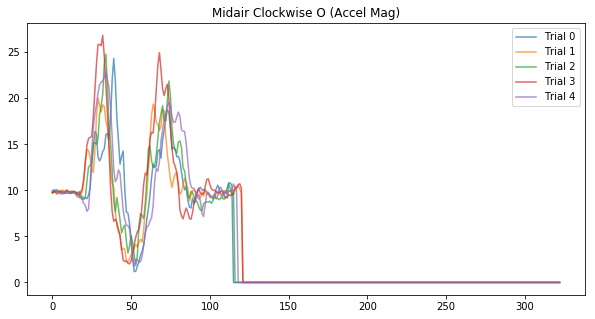

In [5]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


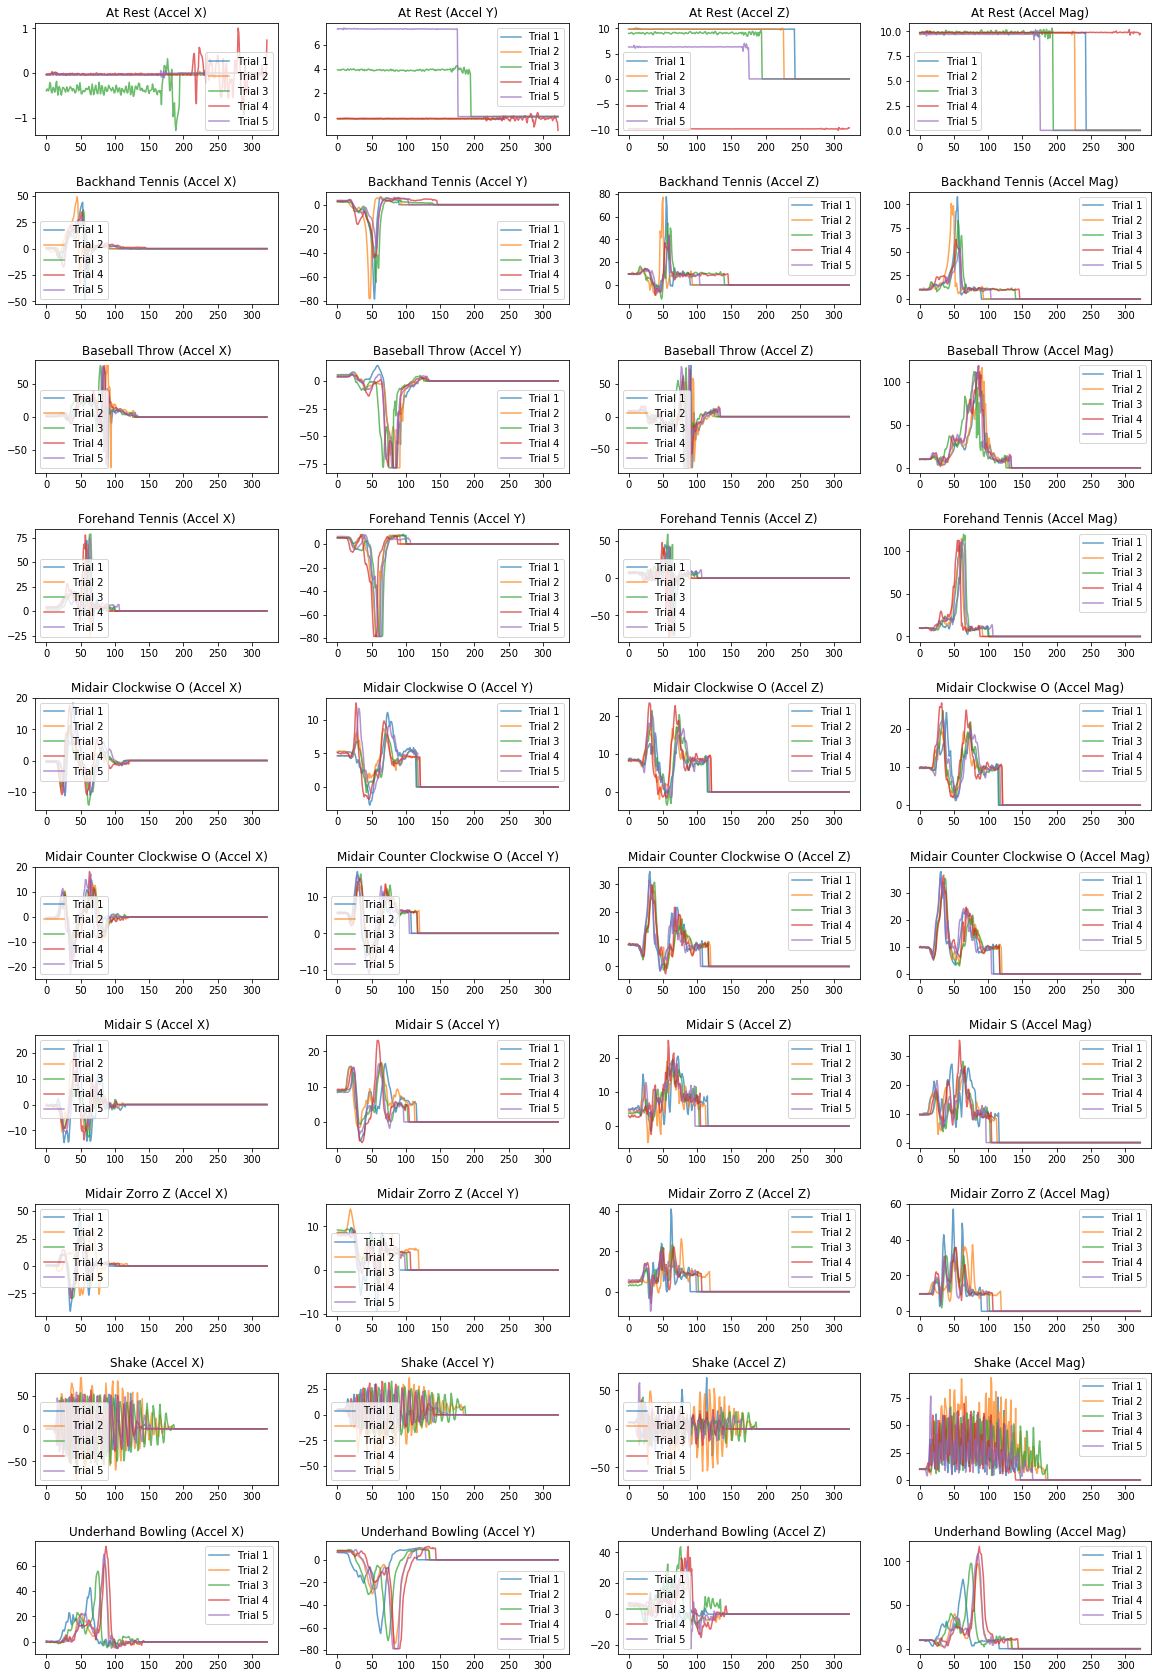

In [6]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1


In [162]:
# In class on Thursday, April 12, I'd like you to start analyzing and comparing these gesture signals.
# Think about:
#  - What kind of filtering might be useful?
#  - What kind of signal transforms? (e.g., ffts)
#  - Is there value in exploring both the accel data AND the gyro data? 
#Smaller movements and differences can be explored with the gyro data whilst bigger and more movement of the phone
#itself would be useful with the accel data.
#  - What is the simplest way we can compare two signals? (scroll down and look for distance.euclidean)?
#  - What classes might you want to create to help you keep things organized? (e.g., your k-fold experiments and results)

# Model-Based ML Exercises
Here is some code for the in-class exercises on Thurs, April 19

In [7]:
# Given the online discussion about k-fold implementations, I thought I would provide my own. Note that sci-kit learn also 
# has built-in functionality for this (I've never used it but worth checking out):
# http://scikit-learn.org/stable/modules/cross_validation.html
from random import randint

# Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial for that fold
# if createNewKFold is True, returns a new random fold, otherwise returns same fold setup as before 
# (this is to better enable repeat experimentation). WARNING: if you are trying to use multiple gesture datasets
# make sure you set createNewKFold=True
fixedFoldsToMapGestureToTrial = None
def generate_kfolds(mapGestureToTrials, numFolds=5, createNewKFold=False):
    global fixedFoldsToMapGestureToTrial
    
    if createNewKFold is False and fixedFoldsToMapGestureToTrial is not None:
        return fixedFoldsToMapGestureToTrial
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gestureName, trials in mapGestureToTrials.items():
        if numFolds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(numFolds, gestureName, len(trials)))


    numGestures = len(mapGestureToTrials)
    tmpMapGestureToTrials = dict()
    for gestureName, trials in mapGestureToTrials.items():
        tmpMapGestureToTrials[gestureName] = list(trials)
    
    gestureNames = list(mapGestureToTrials.keys())

    # create folds
    foldToMapGestureToTrial = list()
    for i in range(0, numFolds):
        curFoldMapGestureToTrial = dict()
        foldToMapGestureToTrial.append(curFoldMapGestureToTrial)
        
        for j in range(0, numGestures):
            curGestureName = gestureNames[j]
            trialList = tmpMapGestureToTrials[curGestureName]
            randTrialIndex = 0
            if (len(trialList) > 0):
                randTrialIndex = randint(0, len(trialList) - 1)

            randTrial = trialList[randTrialIndex]
            curFoldMapGestureToTrial[curGestureName] = randTrial
            del trialList[randTrialIndex]
    
    if fixedFoldsToMapGestureToTrial is None:
        fixedFoldsToMapGestureToTrial = foldToMapGestureToTrial
    
    return foldToMapGestureToTrial

In [8]:
# Print out the folds
numFolds = 5
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials, numFolds)

# debug check folds
foldIndex = 0
print("DEBUG: PRINTING OUT FOLDS")
for fold in foldToMapGestureToTrial:
    print("Fold: ", foldIndex)
    for gestureName, trial in fold.items():
        print("\t Gesture: {} Trial: {}".format(gestureName, trial.trialNum))
    foldIndex = foldIndex + 1

DEBUG: PRINTING OUT FOLDS
Fold:  0
	 Gesture: Backhand Tennis Trial: 1
	 Gesture: Midair Clockwise O Trial: 0
	 Gesture: At Rest Trial: 2
	 Gesture: Midair Zorro Z Trial: 1
	 Gesture: Shake Trial: 0
	 Gesture: Underhand Bowling Trial: 2
	 Gesture: Midair S Trial: 4
	 Gesture: Midair Counter Clockwise O Trial: 1
	 Gesture: Baseball Throw Trial: 0
	 Gesture: Forehand Tennis Trial: 4
Fold:  1
	 Gesture: Backhand Tennis Trial: 4
	 Gesture: Midair Clockwise O Trial: 1
	 Gesture: At Rest Trial: 1
	 Gesture: Midair Zorro Z Trial: 3
	 Gesture: Shake Trial: 3
	 Gesture: Underhand Bowling Trial: 3
	 Gesture: Midair S Trial: 0
	 Gesture: Midair Counter Clockwise O Trial: 3
	 Gesture: Baseball Throw Trial: 1
	 Gesture: Forehand Tennis Trial: 1
Fold:  2
	 Gesture: Backhand Tennis Trial: 2
	 Gesture: Midair Clockwise O Trial: 3
	 Gesture: At Rest Trial: 0
	 Gesture: Midair Zorro Z Trial: 0
	 Gesture: Shake Trial: 2
	 Gesture: Underhand Bowling Trial: 1
	 Gesture: Midair S Trial: 2
	 Gesture: Midair 

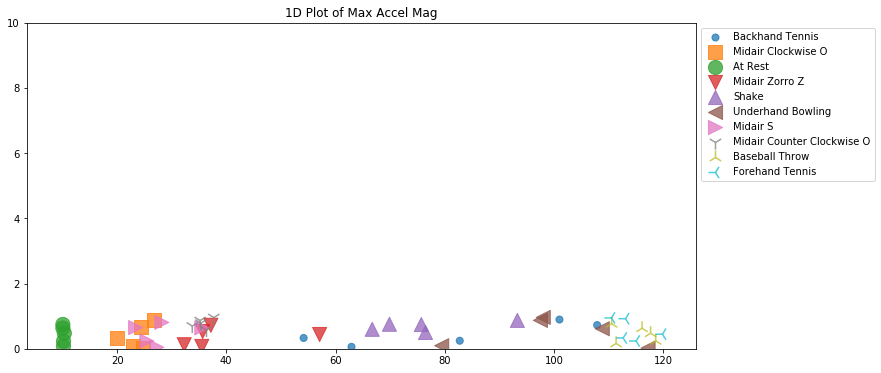

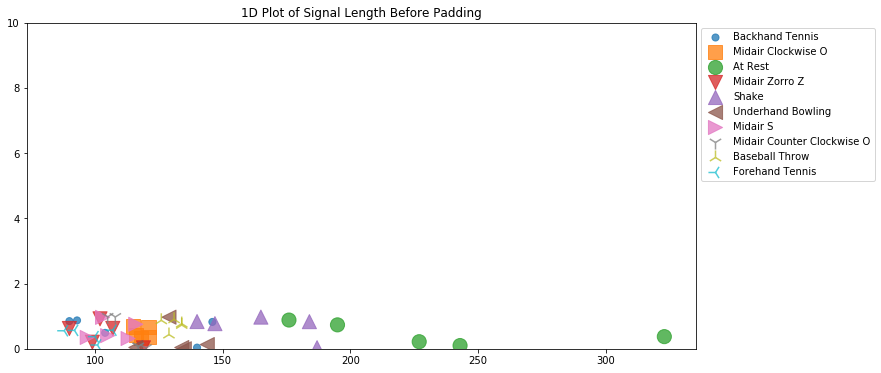

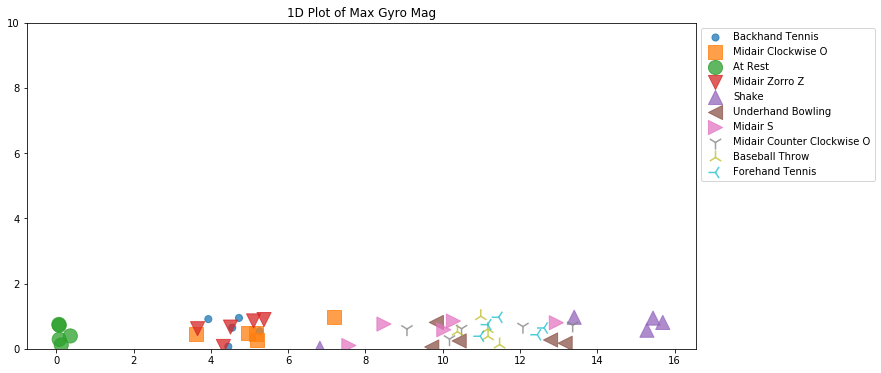

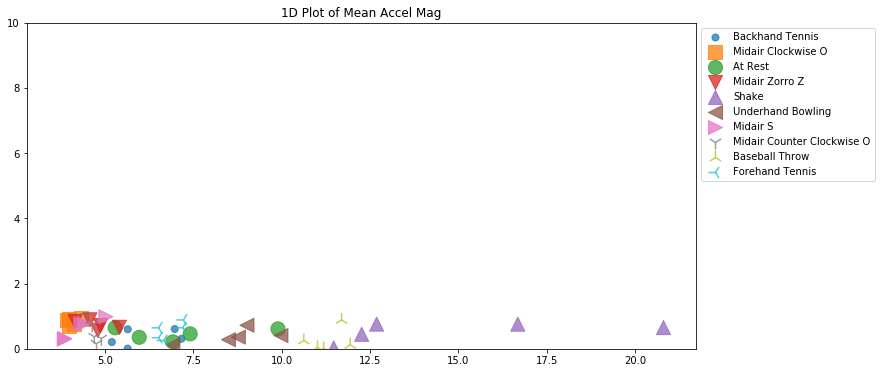

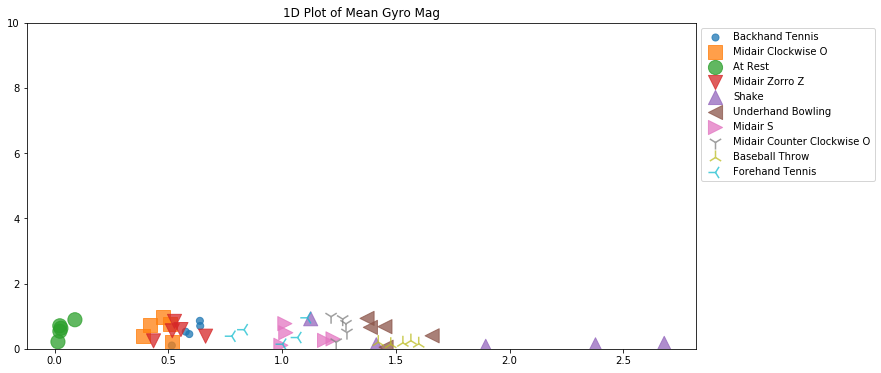

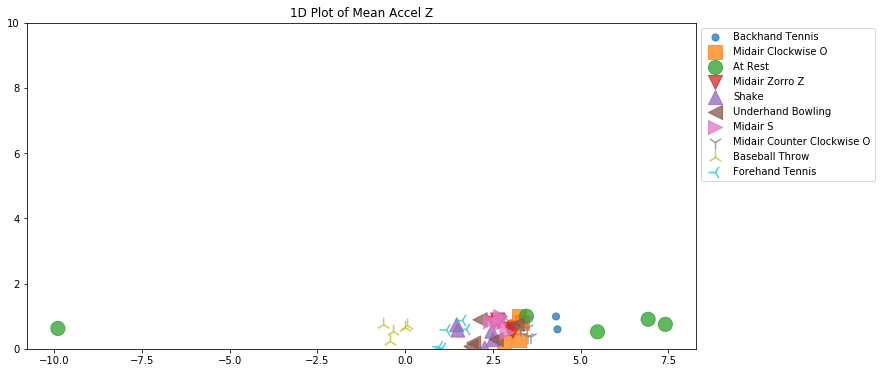

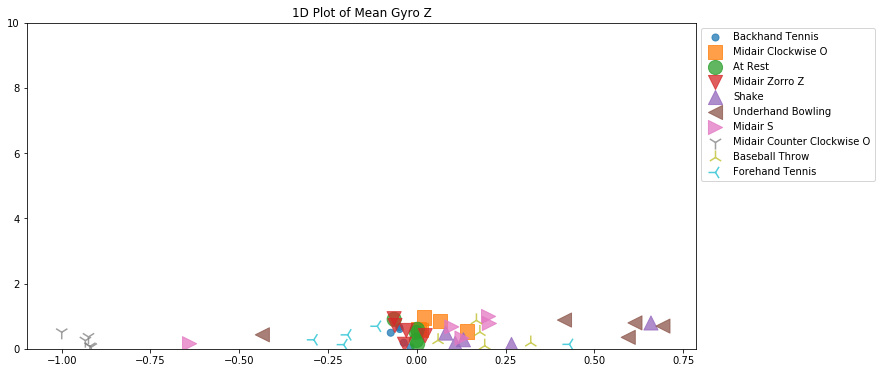

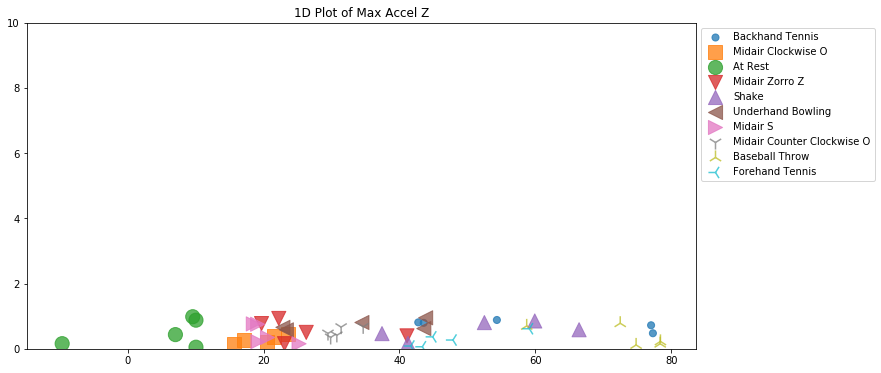

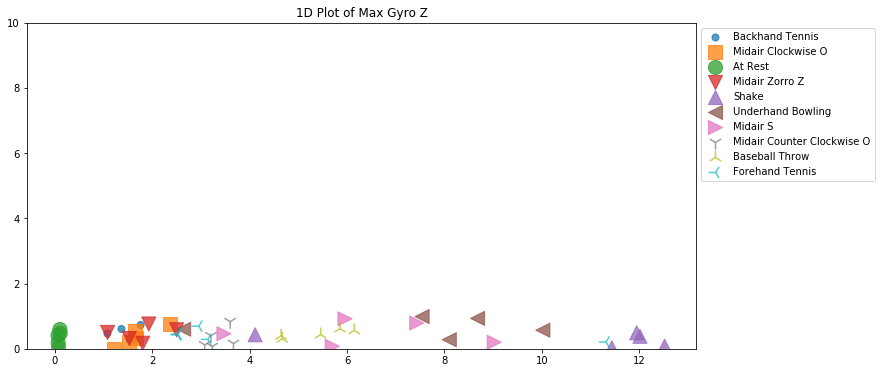

In [9]:
# Playing around with 1D Explorations of data
# TODO: brainstorm and experiment with at least five features that you think might be highly differentiable in the 
# gesture dataset. I've started by plotting two simple features: the maximum magnitude and the length of the trial

import itertools

mapMarkerToDesc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

# Plots the maximum magnitude of each trial's acceleration signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.mag.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max Accel Mag")
plt.show()


# Plots the length of each gesture trial
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.signalLengthBeforePadding for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Signal Length Before Padding")
plt.show()

############## Add your own down here!

# Plots the maximum magnitude of each trial's gyro signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.gyro.mag.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max Gyro Mag")
plt.show()


# Plots the average magnitude of each trial's accel signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.mag.mean() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Mean Accel Mag")
plt.show()


# Plots the average magnitude of each trial's gyro signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.gyro.mag.mean() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Mean Gyro Mag")
plt.show()


# Plots the average z of each trial's gyro signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.z.mean() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Mean Accel Z")
plt.show()


# Plots the average z of each trial's gyro signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.gyro.z.mean() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Mean Gyro Z")
plt.show()


# Plots the max z of each trial's accel signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.z.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max Accel Z")
plt.show()


# Plots the max z of each trial's gyro signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.gyro.z.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max Gyro Z")
plt.show()

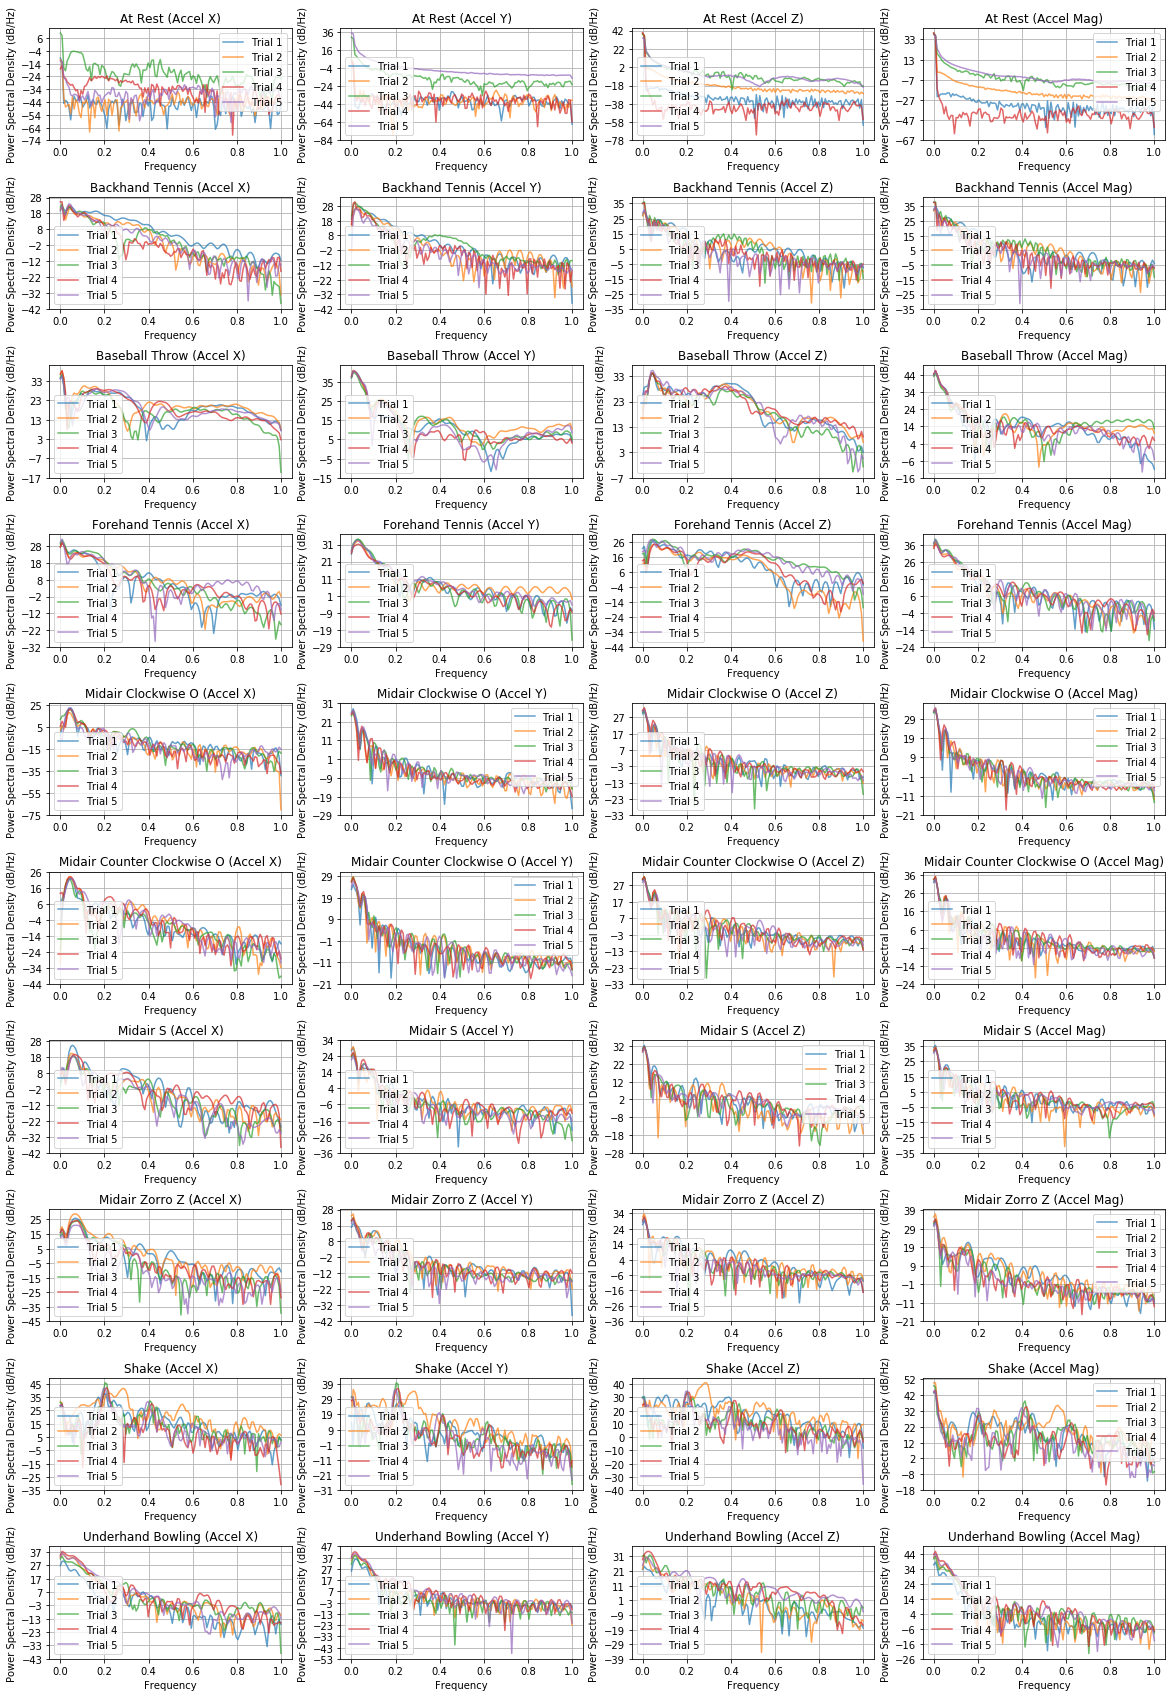

In [10]:
# Now explore the discriminability of 2 dimensions!
# For this exercise, you're going to explore these features in 2D by combining them. Please wait
# to complete this exercise until we get to it in class
# I purposefully did not give you skeleton code here. Please copy/paste a section from the above cell
# and adapt it to plot two features at a time in a scatter plot

####### FREQUENCY
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].psd(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].psd(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].psd(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].psd(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1

# Model-Based Gesture Recognition - SVM

In [222]:
# Now, let's try to build an SVM using some of the features you brainstormed. 
# We're going to start with the simplest possible SVM using only one feature
# 
# Some nice resources:
#  - Official sci-kit learn (Start here!): http://scikit-learn.org/stable/modules/svm.html
#  - A simple classification example using scikit: https://dbaumgartel.wordpress.com/2014/03/10/a-scikit-learn-example-in-10-lines/
#  - A nice video overview of SVM: https://youtu.be/N1vOgolbjSc
#  
#
from sklearn import svm

numFolds = get_min_num_of_trials(mapGestureToTrials)
numGestures = len(mapGestureToTrials)
numTrials = get_total_num_of_trials(mapGestureToTrials)
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials)
    
gestureNames = list(mapGestureToTrials.keys())


y_svm_true = []
y_svm_predict = []


# SVM
# Currently training on all folds
foldIndex = 0
for i in range(0,5):
    foldIndex = i
    mapGestureNameToCorrectMatchCnt = dict()
    mapGestureNameToPredictionResultList = dict()
    trainingData = np.array([])
    classLabels = np.array([])
    for j in range(0, numFolds):
        # print("\tFold: ", i)
        if(j != foldIndex):
            fold = foldToMapGestureToTrial[j]
            for gestureName, trial in fold.items():
                trainingData = np.append(trainingData, trial.accel.mag.max())
                classLabels = np.append(classLabels, trial.gestureName)
    # Setup SVM
    trainingData = trainingData.reshape(-1, 1) # for 1D input feature vectors, we have to reshape like this
    # Training our SVM
    #print(trainingData)
    clf = svm.SVC()
    clf.fit(trainingData, classLabels) 
# Test our SVM
# fold i will be our test fold    
    testFold = foldToMapGestureToTrial[i]
    for gestureName, trial in testFold.items():
        y_svm_true.append(format(gestureName))
        print("Attempting to predict: {}".format(gestureName))
        svmPrediction = clf.predict(trial.accel.mag.max()) ##feature we are concentrating on
        y_svm_predict.append(svmPrediction)
        print("SVM prediction: {}".format(svmPrediction[0]))
        
# for row in range(0,len(classLabels)):
#     print("gestureName={} values={}".format(classLabels[row], trainingData[row]))

Attempting to predict: Forehand Tennis
SVM prediction: Forehand Tennis
Attempting to predict: At Rest
SVM prediction: At Rest
Attempting to predict: Midair Counter Clockwise O
SVM prediction: Midair Clockwise O
Attempting to predict: Backhand Tennis
SVM prediction: Backhand Tennis
Attempting to predict: Underhand Bowling
SVM prediction: Baseball Throw
Attempting to predict: Midair S
SVM prediction: Midair Zorro Z
Attempting to predict: Midair Zorro Z
SVM prediction: Midair S
Attempting to predict: Your Custom Gesture
SVM prediction: Shake
Attempting to predict: Shake
SVM prediction: Underhand Bowling
Attempting to predict: Baseball Throw
SVM prediction: Baseball Throw
Attempting to predict: Midair Clockwise O
SVM prediction: Backhand Tennis
Attempting to predict: Forehand Tennis
SVM prediction: Baseball Throw
Attempting to predict: At Rest
SVM prediction: At Rest
Attempting to predict: Midair Counter Clockwise O
SVM prediction: Midair Counter Clockwise O
Attempting to predict: Backhand

Overall Accuracy Score:  0.41818181818181815 

Accuracy Score by Gesture:
Accuracy score for gesture:  Backhand Tennis 0.2
Accuracy score for gesture:  Forehand Tennis 0.6
Accuracy score for gesture:  Underhand Bowling 0.2
Accuracy score for gesture:  Baseball Throw 0.2
Accuracy score for gesture:  At Rest 1.0
Accuracy score for gesture:  Midair Clockwise O 0.4
Accuracy score for gesture:  Midair Counter Clockwise O 0.6
Accuracy score for gesture:  Midair Zorro Z 0.2
Accuracy score for gesture:  Midair S 0.0
Accuracy score for gesture:  Shake 0.4


Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 2 2 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 1 2 0]
 [0 0 2 3 0 0 0 0 0 0 0]
 [0 2 0 0 2 1 0 0 0 0 0]
 [0 1 0 0 1 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 1 0]
 [0 0 0 0 0 0 4 1 0 0 0]
 [0 0 0 0 0 0 0 0 2 1 2]
 [0 0 2 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 0 4]]
Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.2 0.  0.  0.4 0.4 0.  0.  0.  0.  0. ]
 [0.  0

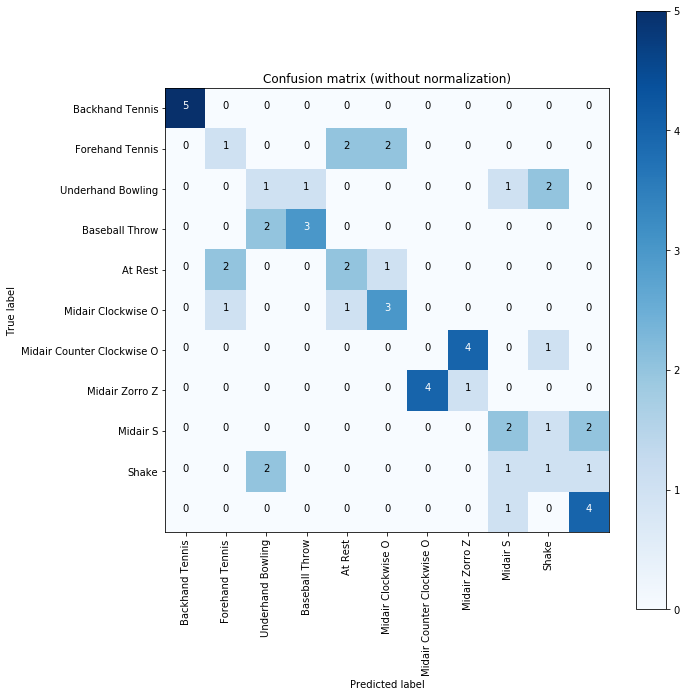

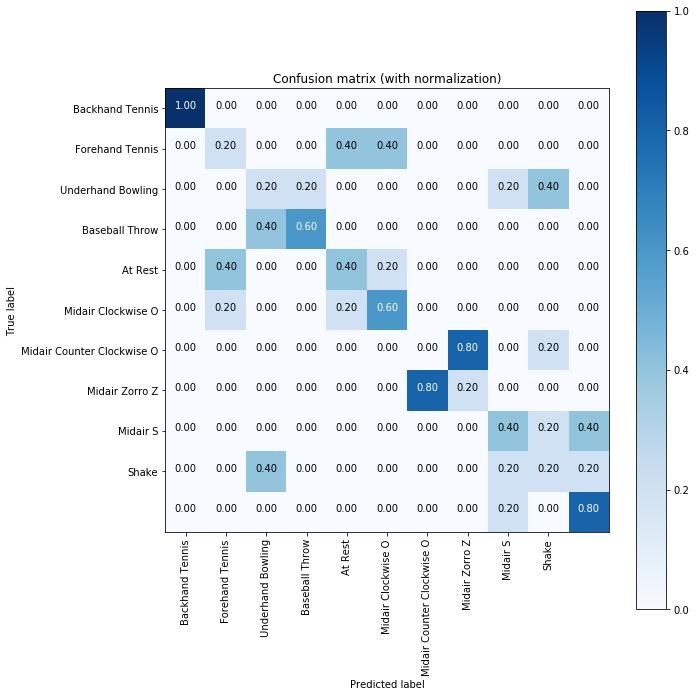

In [223]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print("Overall Accuracy Score: ", accuracy_score(y_svm_true, y_svm_predict), "\n")

print("Accuracy Score by Gesture:")
for l in labels:
    y_true  = []
    y_predict = []
    indices = [i for i, x in enumerate(y_svm_true) if x == l]
    for j in indices:
        y_true.append(l)
        y_predict.append(y_svm_predict[j])
    print("Accuracy score for gesture: ", l, accuracy_score(y_true, y_predict))
    
print("\n")
cm = confusion_matrix(y_svm_true, y_svm_predict)
labels = ["Backhand Tennis", "Forehand Tennis", "Underhand Bowling", "Baseball Throw", "At Rest", 
          "Midair Clockwise O", "Midair Counter Clockwise O", "Midair Zorro Z", "Midair S", "Shake"]

plt.figure(figsize = (10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure(figsize = (10,10))
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()

# Shape-Based Gesture Recognition - DTW

In [11]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw


# Creates the folds
numFolds = get_min_num_of_trials(mapGestureToTrials)
numGestures = len(mapGestureToTrials)
numTrials = get_total_num_of_trials(mapGestureToTrials)
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials)
gestureNames = list(mapGestureToTrials.keys())

def dtw_create_folds(foldIndex):
    mapGestureNameToCorrectMatchCnt = dict()
    mapGestureNameToPredictionResultList = dict()
    trainingData = np.array([])
    classLabels = np.array([])
    for j in range(0, numFolds):
        #print("\tFold: ", j)
        if(j != foldIndex):
            fold = foldToMapGestureToTrial[j]
            for gestureName, trial in fold.items():
                #trainingData = np.vstack((trainingData,trial))
                trainingData = np.append(trainingData, trial) #APPEND TRIALS
                #print(trial.accel.x)
                classLabels = np.append(classLabels, trial.gestureName)  
    return(trainingData)

def dtw_calc(trial, trailTrain):
    sum_train = 0
    x = signal.detrend(trial.accel.x)
    y = signal.detrend(trialTrain.accel.x)
    distance, path = fastdtw(x, y, dist=euclidean)
    sum_train += distance
    
    x = signal.detrend(trial.accel.y)
    y = signal.detrend(trialTrain.accel.y)
    distance, path = fastdtw(x, y, dist=euclidean)
    sum_train += distance
    
    #x = trial.accel.z
    #y = trialTrain.accel.z
    #distance, path = fastdtw(x, y, dist=euclidean)
    #sum_train += distance
    
    return sum_train
        
# Test our DTW
# fold i will be our test fold
y_dtw_true = []
y_dtw_predict = []
min_dis = sys.maxsize
min_ges_name = "" 

for i in range(0,5):
    trainingData = dtw_create_folds(i)
    testFold = foldToMapGestureToTrial[i]
    for gestureName, trial in testFold.items():
        print("Attempting to predict: {}".format(gestureName))
        y_dtw_true.append(format(gestureName))
        for trialTrain in trainingData:
            trial_distance = dtw_calc(trial, trialTrain)
            if( trial_distance < min_dis ):
                min_dis = trial_distance          
                min_ges_name = trialTrain.gestureName
            
        print("DTW prediction: ", min_ges_name)
        y_dtw_predict.append(min_ges_name)
        min_dis = sys.maxsize

#print(y_dtw_true)
#print(y_dtw_predict)
        


Attempting to predict: Backhand Tennis
DTW prediction:  Backhand Tennis
Attempting to predict: Midair Clockwise O
DTW prediction:  Midair Clockwise O
Attempting to predict: At Rest
DTW prediction:  At Rest
Attempting to predict: Midair Zorro Z
DTW prediction:  Midair Zorro Z
Attempting to predict: Shake
DTW prediction:  Shake
Attempting to predict: Underhand Bowling
DTW prediction:  Underhand Bowling
Attempting to predict: Midair S
DTW prediction:  Midair S
Attempting to predict: Midair Counter Clockwise O
DTW prediction:  Midair Counter Clockwise O
Attempting to predict: Baseball Throw
DTW prediction:  Baseball Throw
Attempting to predict: Forehand Tennis
DTW prediction:  Forehand Tennis
Attempting to predict: Backhand Tennis
DTW prediction:  Backhand Tennis
Attempting to predict: Midair Clockwise O
DTW prediction:  Midair Clockwise O
Attempting to predict: At Rest
DTW prediction:  At Rest
Attempting to predict: Midair Zorro Z
DTW prediction:  Midair Zorro Z
Attempting to predict: Sha

Overall Accuracy Score:  1.0 

Accuracy Score by Gesture:
Accuracy score for gesture:  Backhand Tennis 1.0
Accuracy score for gesture:  Forehand Tennis 1.0
Accuracy score for gesture:  Underhand Bowling 1.0
Accuracy score for gesture:  Baseball Throw 1.0
Accuracy score for gesture:  At Rest 1.0
Accuracy score for gesture:  Midair Clockwise O 1.0
Accuracy score for gesture:  Midair Counter Clockwise O 1.0
Accuracy score for gesture:  Midair Zorro Z 1.0
Accuracy score for gesture:  Midair S 1.0
Accuracy score for gesture:  Shake 1.0


Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0

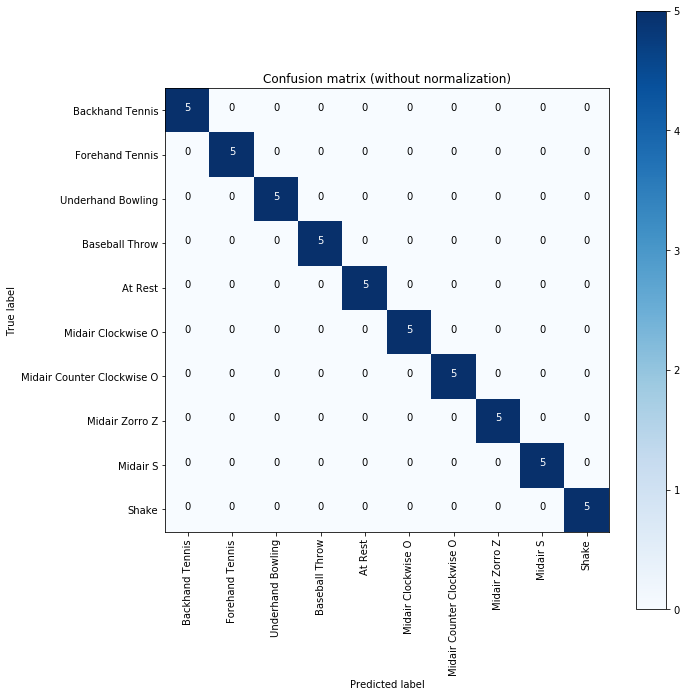

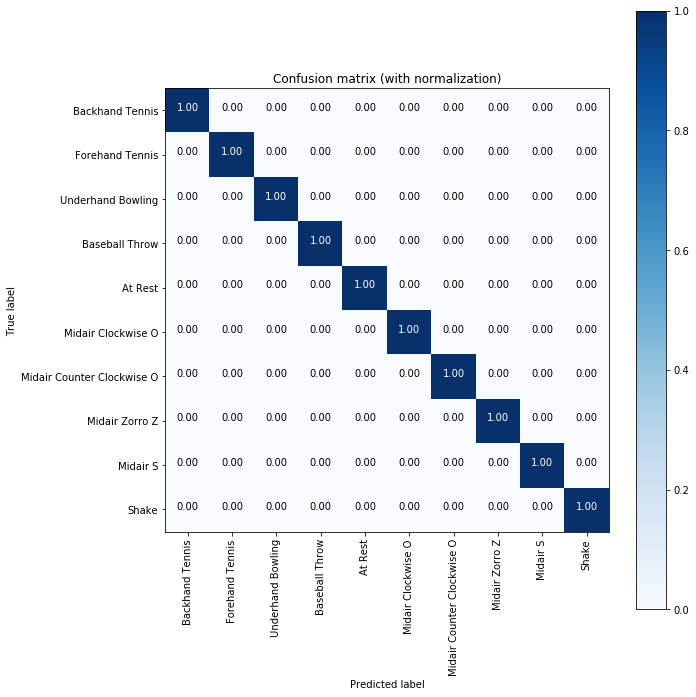

In [14]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


labels = ["Backhand Tennis", "Forehand Tennis", "Underhand Bowling", "Baseball Throw", "At Rest", 
          "Midair Clockwise O", "Midair Counter Clockwise O", "Midair Zorro Z", "Midair S", "Shake"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print("Overall Accuracy Score: ", accuracy_score(y_dtw_true, y_dtw_predict), "\n")

print("Accuracy Score by Gesture:")
for l in labels:
    y_true  = []
    y_predict = []
    indices = [i for i, x in enumerate(y_dtw_true) if x == l]
    for j in indices:
        y_true.append(l)
        y_predict.append(y_dtw_predict[j])
    print("Accuracy score for gesture: ", l, accuracy_score(y_true, y_predict))
    
print("\n")
cm = confusion_matrix(y_dtw_true, y_dtw_predict)

plt.figure(figsize = (10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure(figsize = (10,10))
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()

# Sandbox
Everything below here is a Sandbox for you to play. You could do this in another Jupyter Notebook but I often have some cells at the bottom of my notebook that let's me experiment with and play with Python and the numpy, scipy, etc. libraries. I've added some example playground cells that I used when making the assignment.

Feel free to delete all of these cells but I thought they might be informative for you.

In [186]:
import numpy as np
x = np.array([1,2,3])
y = np.array([1,2,3])
z = np.array([1,2,3])

t = np.array([])
t = np.insert((x,y))
print(t)

sum1 = np.add(x, y, z)
print(sum1)

x = np.array([1,2,3])
y = np.array([1,2,3])
z = np.array([1,2,3])

sum2 = x + y + z
print(sum2)

TypeError: insert() missing 2 required positional arguments: 'obj' and 'values'

In [ ]:
# Testing to see if the numpy 'where' method supports string matching
a = np.array(['apple', 'orange', 'apple', 'banana'])

indicesWhereThereAreApples = np.where(a == 'apple')

print (indicesWhereThereAreApples)
print (a[indicesWhereThereAreApples])

In [ ]:
# Playing around with classes in Python 3. Notice how just like in Javascript, you can add a new member variable
# just by starting to use it!

class DummyClass:
    def __init__(self, variable):
        self.testVar = variable
        

dummy = DummyClass(5)
print(dummy.testVar)
dummy.newVar = 7 # added a new member variable called newVar here. Cool!
print(dummy.newVar)
vars(dummy) # prints out the member variables of the class

In [ ]:
# Experimenting with how folding and unfolding tuples work
testTuple = (1,2,3,4,5,6,7,8,9,10)
print(testTuple)
print(*testTuple)
print(*testTuple[5:])

In [ ]:
# Experimenting with how we delete things out of lists
import random
testDict = {"a":1, "c":3, "d":4}
a = list(testDict.keys())
print(a)
random.shuffle(a)
print(a)
del a[1]
print(a)

In [ ]:
# Playing around with how we can split up and combine lists in Python
testList = [1, 2, 3, 4, 5]
index = 4
print(testList[0:index] + testList[index + 1:5])

index = 3
print(testList[0:index] + testList[index + 1:5])

print(testList[index:])
print(testList[:index])

In [ ]:
# playing around with numpy subtraction. In order for these operations to work
# the arrays must be of the same size
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([1, 2, 4, 5, 5])
np2 - np1

np3 = [1, 2, 3]

# the (0,2) value tells pad to pad 0 times in the front of array
# and three times to the end of array. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
np3_resized = np.pad(np3, (0, 2), 'constant', constant_values=0)
np3_resized - np2

In [ ]:
# Find Euclidean distance between two numpy vector arrays
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([5, 4, 3, 2, 1])

# First, we'll try numpy's way of determining Euclidean distance
# See: https://stackoverflow.com/a/1401828
npDist = np.linalg.norm(np2 - np1)
print(npDist)

# Next, we'll try scipy's way
# See: https://stackoverflow.com/a/21986532
from scipy.spatial import distance

scipyDist = distance.euclidean(np2,np1)
print(scipyDist)

In [ ]:
# detrend playground
from scipy import signal
a = np.random.rand(50) * 50
print(a)
b = np.array(range(0,50))
c = a + b

fig, axes = plt.subplots()
# axes.plot(a)
# axes.plot(b)
axes.plot(c, label="c (avg={:0.1f})".format(np.mean(c)))
c_detrended = signal.detrend(c)
axes.plot(c_detrended, label="c_detrended (avg={:0.1f})".format(np.mean(c_detrended)))
axes.legend()


In [ ]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ["cat", "ant", "cat", "cat", "ant", "bird", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat", "bird"]
labels=["ant", "bird", "cat"]
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()

In [ ]:
# Here's some sample code for building up a multi-dimensional feature vector
# Feel free to use this approach (or not) in your homework

# Example create_feature_vector function that returns a 3D feature vector for the given trial        
def create_simple_feature_vector(trial):
    return [trial.accel.mag.max(), trial.accel.signalLengthBeforePadding, trial.gyro.mag.max()]
    
# takes in the current testFold, the trainingFolds, and a create_feature_vector function
# the create_feature_vector function creates feature vectors given a Trial object
# I suggest creating multiple different create_feature_vector functions that you pass
# in here and test (this will allow you to easily compare different feature vectors)
def get_svm_input(testFold, trainingFolds, create_feature_vector):
    
    # calculate the number of training trials
    numOfTrainingTrials = 0
    for trainingFold in trainingFolds:
        numOfTrainingTrials = numOfTrainingTrials + len(trainingFold)
        
    # Now figure out the number of features from the create_feature_vector call
    # This is just a dummy call to figure out the number of features in order to
    # properly initialize our trainingData matrix
    tmpTrainingTrial = random.choice(list(trainingFolds[0].values()))
    numFeatures = len(create_feature_vector(tmpTrainingTrial))
    print("The feature vector size is: {}".format(numFeatures))
     
    # now we can setup our training data structures  
    # each row in our trainingData matrix corresponds to a trial
    # and each column corresponds to a feature
    trainingData = np.zeros([numOfTrainingTrials, numFeatures])
    trainingTrials = list()
    trainingLabels = np.array([])
  
    # Build up the training data and also keep track of the class labels (in trainingLabels)
    row = 0
    for trainingFold in trainingFolds:
        for trainingGestureName, trainingTrial in trainingFold.items():
            trainingData[row] = create_feature_vector(trainingTrial)
            trainingLabels = np.append(trainingLabels, trainingTrial.gestureName)
            trainingTrials.append(trainingTrial)
            row = row + 1
    
    # Now setup the testData data structure
    testData = np.zeros([len(testFold), numFeatures])
    testRow = 0
    groundtruthLabels = list()
    testTrials = list()
    for testGestureName, testTrial in testFold.items():
        testTrials.append(testTrial)
        testData[testRow] = create_feature_vector(testTrial)
        groundtruthLabels.append(testGestureName)
        testRow = testRow + 1
        

# This is an example of how you would call the get_svm_input method
# You'll have to figre out how to appropriately put this in a for loop and use it...  
#svmInput = get_svm_input(testFold, trainingFolds, create_feature_vector)

# Unpack the tuple into more semantic variable names
#trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials = svmInput
        